In [1]:
from quimb import *

p0 = rand_ket(2**10)
h = ham_heis(10, sparse=True)
evo = Evolution(p0, h)


Update it in a single shot to a new time and get the state,

In [2]:
evo.update_to(1)
evo.pt

[[ 0.001538+0.012379j]
 [-0.00541 +0.02611j ]
 [-0.012026+0.015335j]
 ...
 [-0.041381+0.02054j ]
 [-0.004961-0.001546j]
 [-0.019127+0.002967j]]

Lazily generate the state at multiple times:

In [3]:
for pt in evo.at_times([2, 3, 4]):
    print(expec(pt, p0))

0.0005106405568608293
0.009995197474010302
0.00525130789898347


In [4]:
p0 = rand_product_state(10)
h = ham_heis(10, sparse=True)

dims = [2] * 10
sysa, sysb = (0, 1), (2, 3)

def calc_t_and_logneg(t, pt):
    ln = logneg_subsys(pt, dims, sysa, sysb)
    return t, ln

evo = Evolution(p0, h, compute=calc_t_and_logneg, progbar=True)
evo.update_to(1)

ts, lns = zip(*evo.results)

100%|##########| 100/100 [00:00<00:00, 6697.06%/s]


In [5]:
ts

(0.0,
 0.2312290367760555,
 0.4377093533282588,
 0.6399835221505082,
 0.8549423071920399,
 1.0)

In [6]:
lns

(0.0,
 0.16992190183490394,
 0.2865537529923966,
 0.3808698480199881,
 0.4716243573297176,
 0.5295261025477127)

In [7]:
def calc_t(t, _):
    return t

def calc_logneg(_, pt):
    return logneg_subsys(pt, [2]*10, 0, 1)

evo = Evolution(p0, h, compute={'t': calc_t, 'ln': calc_logneg}, progbar=True)
evo.update_to(1)

100%|##########| 100/100 [00:00<00:00, 4243.44%/s]


In [8]:
evo.results

{'t': [0.0,
  0.2312290367760555,
  0.4377093533282588,
  0.6399835221505082,
  0.8549423071920399,
  1.0],
 'ln': [0.0,
  0.15268909733170494,
  0.2827184207625697,
  0.40032861740248604,
  0.5081441062956807,
  0.5669364519710873]}

In [9]:
class MyTimeDepIsingHam:
    
    def __init__(self, L):
        self.h_interaction = ham_ising(L, sparse=True, jz=1.0, bx=0.0, cyclic=False)
        self.h_field = ham_ising(L, sparse=True, jz=0.0, bx=1.0, cyclic=False)
    
    def __call__(self, t):
        return self.h_interaction + cos(t) * self.h_field

In [10]:
L = 16

# our initial state
psi0 = neel_state(L)

# instantiate the ham object, it's __call__ method will be used by Evolution
fn_ham_t = MyTimeDepIsingHam(L)

We still want to compute some properties during the evolution:

In [11]:
compute = {
    'time': lambda t, p: t,
    'entropy': lambda t, p: entropy_subsys(p, dims=[2] * L, sysa=range(L // 2))
}

Now we set up the evolution object again:

In [12]:
evo = Evolution(psi0, fn_ham_t, progbar=True, compute=compute)

In [13]:
evo.update_to(10)

100%|##########| 100/100 [00:11<00:00,  8.77%/s]


We can plot the half chain entropy that we computed on the fly:

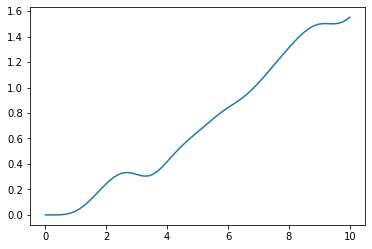

In [14]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(evo.results['time'], evo.results['entropy'])

Or we can use the final state:

In [15]:
fidelity(psi0, evo.pt)

0.003302180752068526